Importing everything we'll be using to examine the data.

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

Using the dataset from NPS Mortality Dashboard to create df using pandas function to import first the file, and then parse to only show the sheet that has the data.   

In [9]:
df = pd.ExcelFile(r"../data/NPS-Mortality-Data-CY2007-to-CY2024-Released-August-2024.xlsx")
df = df.parse(sheet_name="CY2007-Present Q2")
df.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,65+,Not Reported
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Fatal injury,Male,Not Reported,Vessel Related
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,Not Reported,Vessel Related
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,15-24,Driving
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,45-54,Driving


In [10]:
print(df.columns)

Index(['Incident Date', 'Park Name', 'Cause of Death',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ',
       'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity'],
      dtype='object')


In [12]:
print(df.columns.tolist())


['Incident Date', 'Park Name', 'Cause of Death', 'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ', 'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity']


Now that I know the column names, I'm going to make a pie chart with the percentage of deaths by cause. I think this is a good visual starting place to see if there are some major causes we could look at more closely.

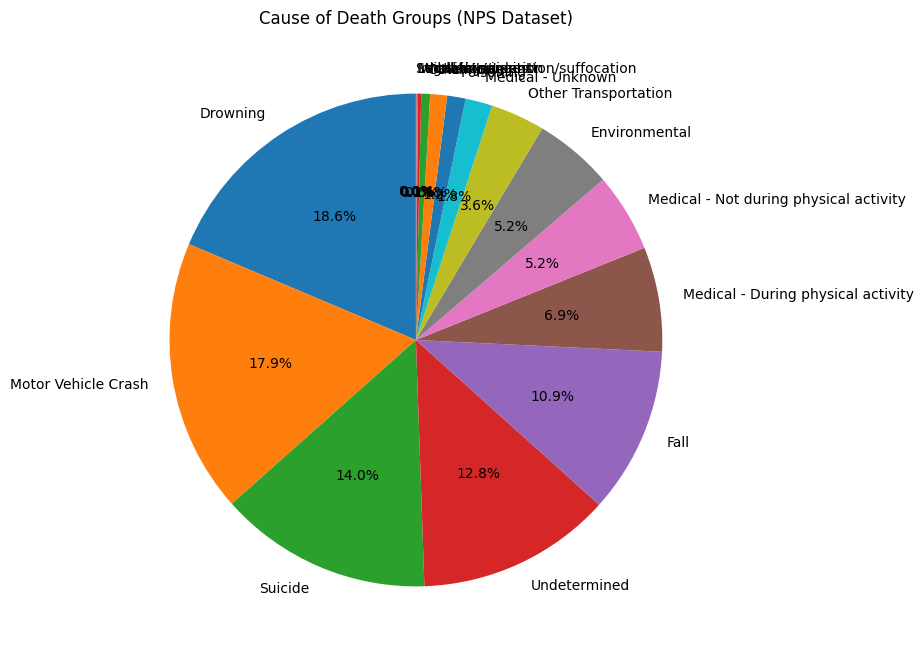

In [13]:
cause_counts = df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "].value_counts()

cause_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(8,8),
    startangle=90
)

plt.ylabel("")
plt.title("Cause of Death Groups (NPS Dataset)")
plt.show()


We can see some major common causes, but there are also a lot of less common causes that you can't really read on the pie chart. I'm going to look at the data to combine some of the smaller sections into one "other" piece.

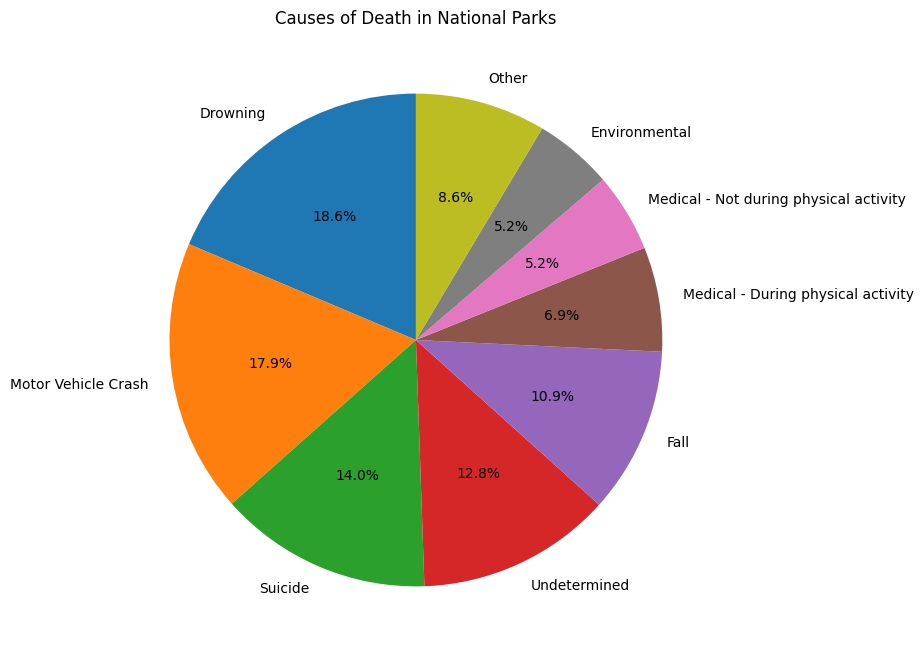

In [19]:
# Step 1: Count values
cause_counts = df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "].value_counts()

# Step 2: Convert to percentages
percentages = cause_counts / cause_counts.sum() * 100

# Step 3: Separate into major vs. small (<5%)
major_causes = percentages[percentages >= 5]
other_total = percentages[percentages < 5].sum()

if other_total > 0:
    major_causes["Other"] = other_total

# Step 4: Plot
major_causes.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(8, 8),
    startangle=90
)

plt.ylabel("")
plt.title("Causes of Death in National Parks")
plt.show()
